In [133]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load SXR phantoms

In [135]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples_fine_discretization/psis.npy')
sxr_samples = np.load('../dataset_generation/sxr_samples_fine_discretization/sxr_samples.npy')
alphas = np.load('../dataset_generation/sxr_samples_fine_discretization/alpha_random_values.npy')
trim_val = np.load('../dataset_generation/sxr_samples_fine_discretization/trimming_values.npy')

In [136]:
psis.shape

(2000, 240, 80)

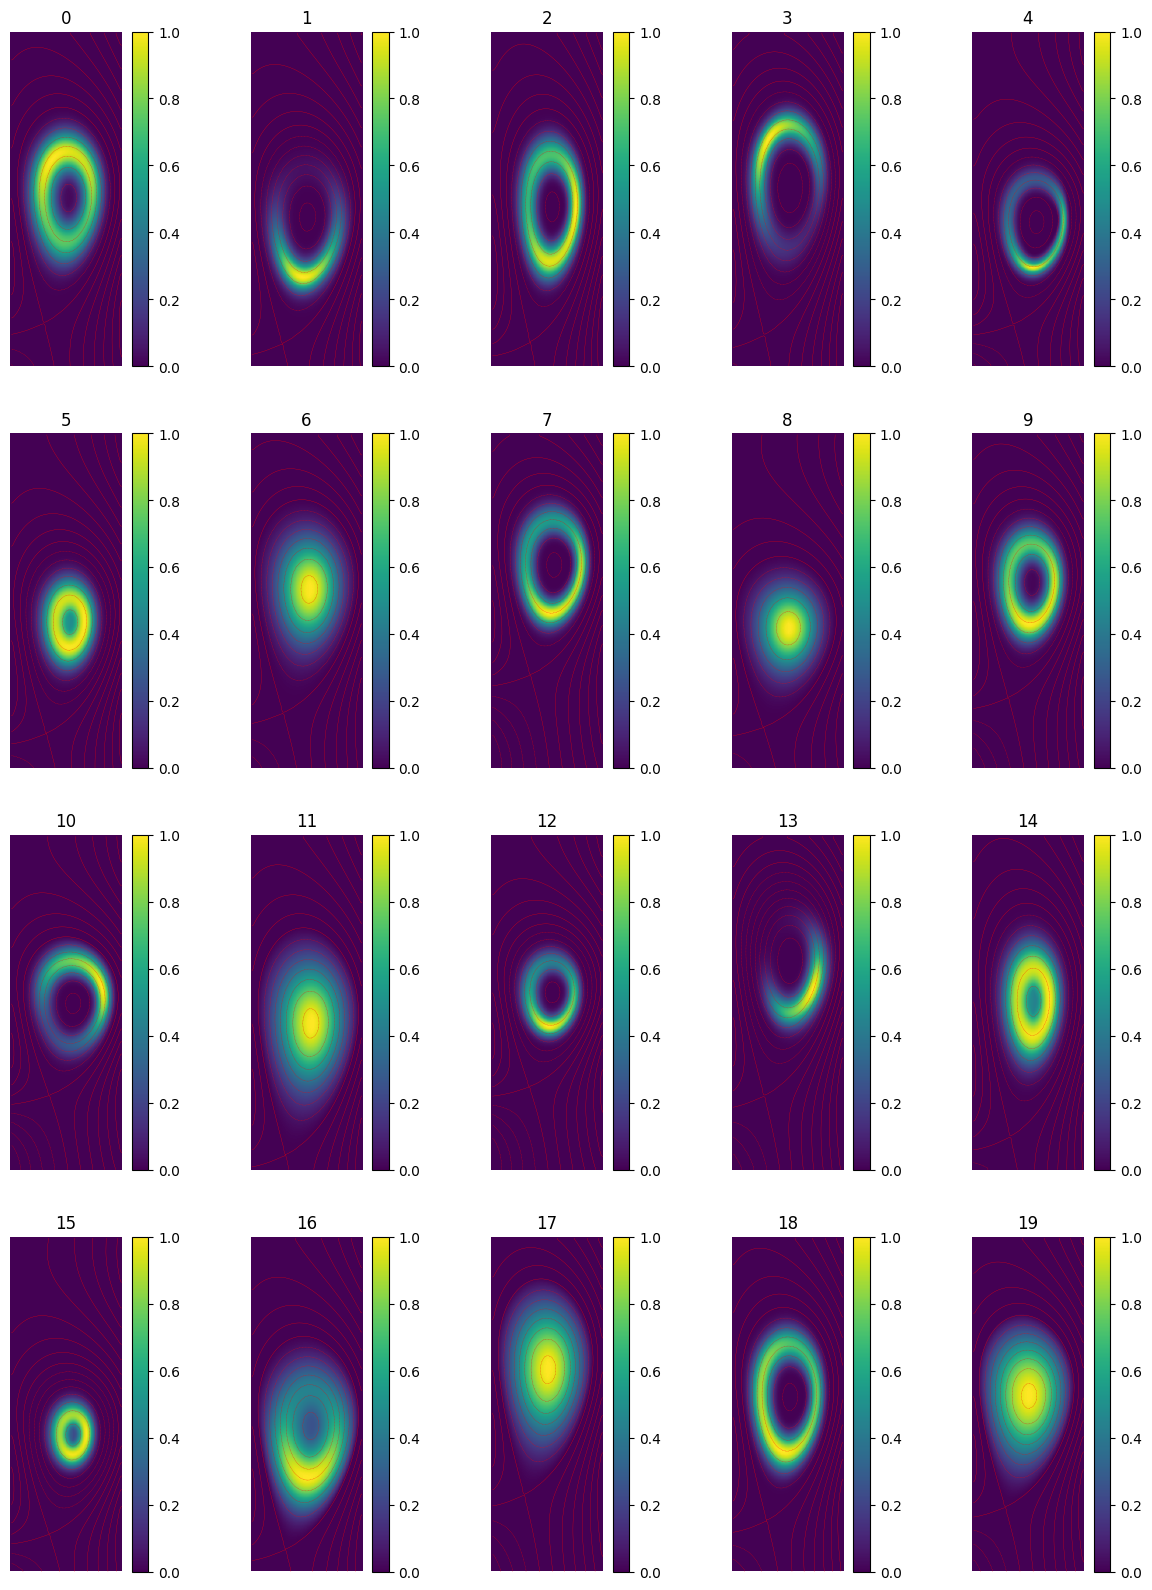

In [137]:
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        im=ax[i,j].imshow(sxr_samples[i*5+j, 0, :, :].squeeze())
        ax[i, j].contour(psis[i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(i*5+j))
plt.show()

# Hyperparameter tuning

We run hyperparameter tuning techniques on 100 SXR phantoms.

In [260]:
idx = 0
ground_truth=sxr_samples[idx,0,:,:].squeeze()
psi=psis[idx,:,:]
alpha=alphas[idx]
trim_val_=trim_val[idx,:]

In [261]:
fwd_fine=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr_fine_grid.npz')
fwd_coarse=sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz')
tomo_data = fwd_fine.dot(ground_truth.flatten())
# plt.plot(tomo_data)
# plt.plot(np.ones(tomo_data.size)*np.mean(tomo_data))
sigma_err = 0.05 * np.mean(tomo_data)
print("sigma_err = {:.2e}".format(sigma_err))

sigma_err = 7.79e-03


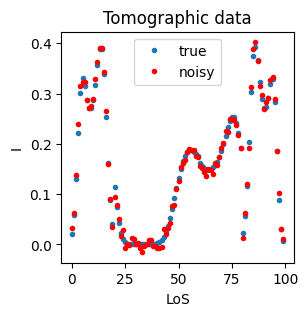

In [285]:
reg_fct_type = "anisotropic"
# Define functionals
f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi, sigma_err=sigma_err, reg_fct_type=reg_fct_type, alpha=alpha, plot=True)
mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=f.dim_shape[1:], trim_values_x=trim_val_)
mask_tcv = tomo_helps.define_tcv_mask(dim_shape=f.dim_shape[1:])

## Hyperparameter tuning

**Regularization parameter**

Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



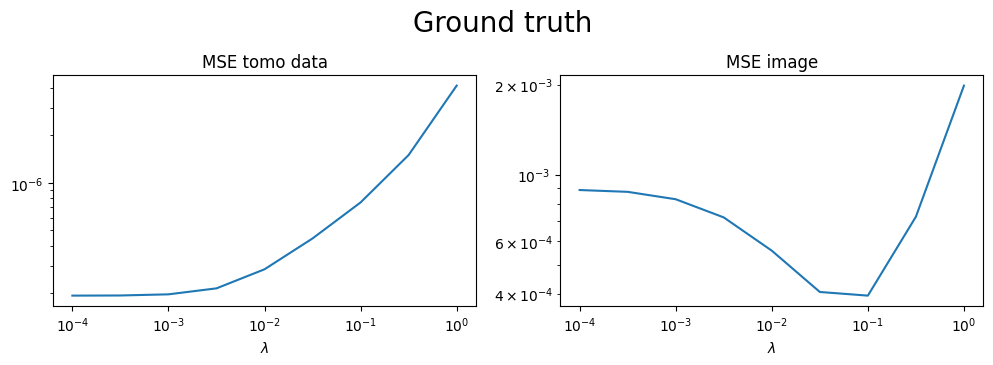

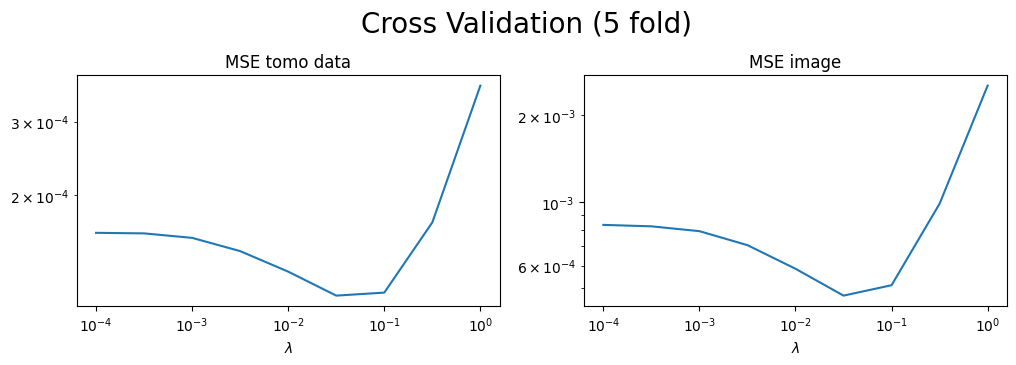

In [263]:
# Tune regularization parameter
#reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["SAPG"],
#                                                    sapg_max_iter=int(1e4), reg_params=np.logspace(-6,0,7), plot=True)
reg_param_tuning_data = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["GT", "CV_full"], ground_truth=ground_truth,
                                                    with_pos_constraint=True, clipping_mask=mask_core,
                                                    cv_strategy="random",
                                                    reg_params=np.logspace(-4,0,9), plot=True)


**Anisotropic Parameter**

Tuning regularization parameter: comparison to ground truth (`GT`)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



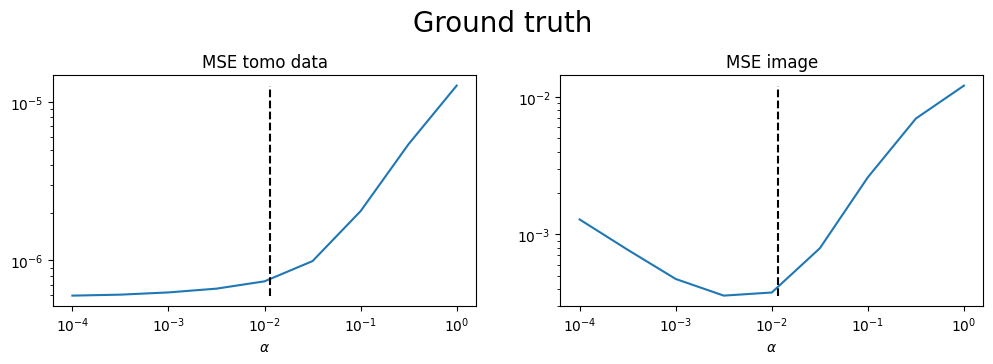

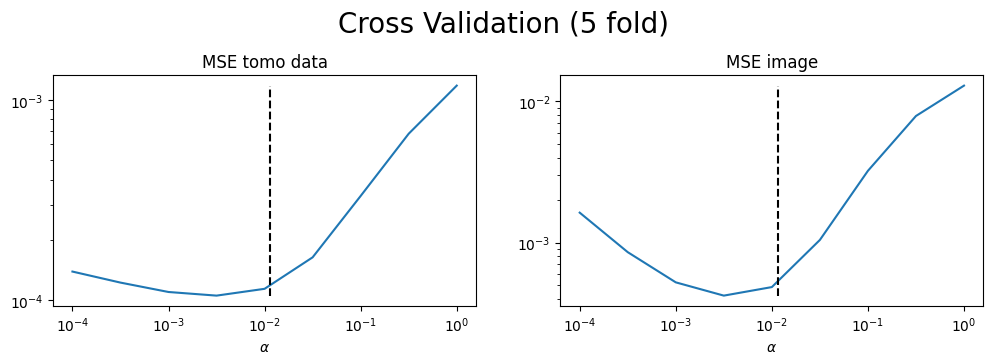

In [264]:
anis_param_tuning_data = hyper_tune.anis_param_tuning(f, g, reg_param=0.1,
                                                        tuning_techniques=["GT", "CV_full"], ground_truth=ground_truth,
                                                        with_pos_constraint=True, clipping_mask=mask_core,
                                                        cv_strategy="random",
                                                        anis_params=np.logspace(-4,0,9), plot=True)

In [265]:
g = hyper_tune._redefine_anis_param_logprior(g, anis_param_tuning_data["CV_full"][0, np.argmin(anis_param_tuning_data["CV_full"][1,:])])

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


In [266]:
tt=time.time()
im_MAP = bcomp.compute_MAP(f, g, 0.1, with_pos_constraint=True, clipping_mask=mask_core)
print(time.time()-tt)

INFO -- [2024-12-10 11:06:45.757925] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-10 11:06:46.146383] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-10 11:06:46.231887] Iteration 1_209
	iteration: 1209
	N_iter: 1210
	RelError[x]: 0
INFO -- [2024-12-10 11:06:46.232570] Stopping Criterion satisfied -> END
0.48041701316833496


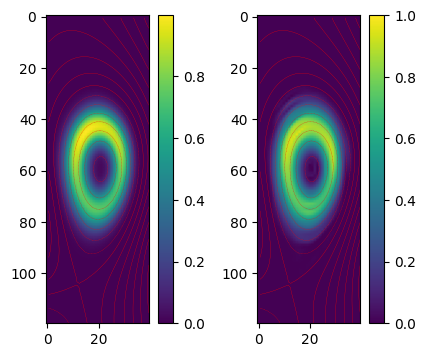

In [267]:
fig,ax=plt.subplots(1,2,figsize=(5,4))
# im=ax[0].imshow(ground_truth.squeeze())
# plt.colorbar(im, ax=ax[0])
# ax[0].contour(psi, origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[0].imshow(skimt.resize(ground_truth.squeeze(), f.dim_shape[1:], anti_aliasing=False, mode='edge'))
plt.colorbar(im, ax=ax[0])
ax[0].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
im=ax[1].imshow((im_MAP).squeeze(), vmax=1)
plt.colorbar(im, ax=ax[1])
ax[1].contour(skimt.resize(psi, f.dim_shape[1:], anti_aliasing=False, mode='edge'), origin="lower", levels=15, antialiased=True, colors="r", linewidths=0.2)
plt.show()

In [268]:
np.max(im_MAP)

np.float64(0.9525552932466821)

# Uncertainty Quantification

In [270]:
uq_data = bcomp.run_ula(f, g, 0.1, psi, trim_val_,
            with_pos_constraint=True,
            clip_iterations="core",
            compute_stats_wrt_MAP=True,
            estimate_quantiles=True)

INFO -- [2024-12-10 11:07:00.933571] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2024-12-10 11:07:01.757418] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2024-12-10 11:07:01.956355] Iteration 1_209
	iteration: 1209
	N_iter: 1210
	RelError[x]: 0
INFO -- [2024-12-10 11:07:01.958039] Stopping Criterion satisfied -> END
Running 100000 ULA iterations
iteration  10000
iteration  20000
iteration  30000
iteration  40000
iteration  50000
iteration  60000
iteration  70000
iteration  80000
iteration  90000
iteration  100000


In [271]:
import src.tomo_fusion.tools.plotting_fcts as tomo_plots

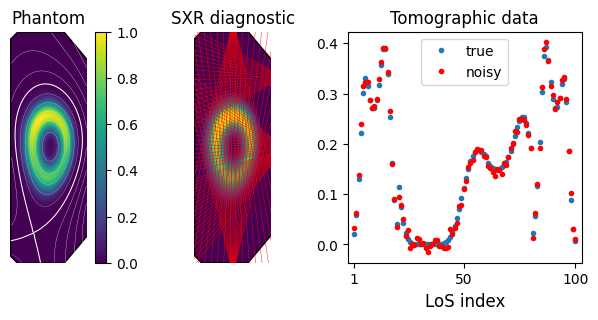

In [273]:
tomo_plots.plot_phantom_and_sxr_diag(ground_truth=ground_truth, psi=psi, f=f, tcv_plot_clip=True)

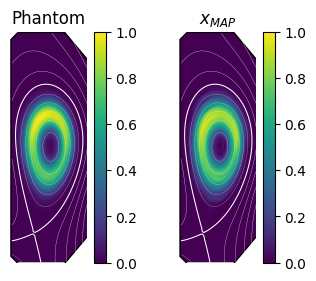

In [274]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True)

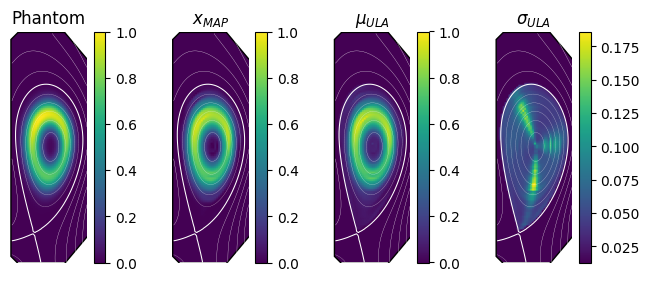

In [275]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True,
                        cmaps=["viridis", "viridis", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

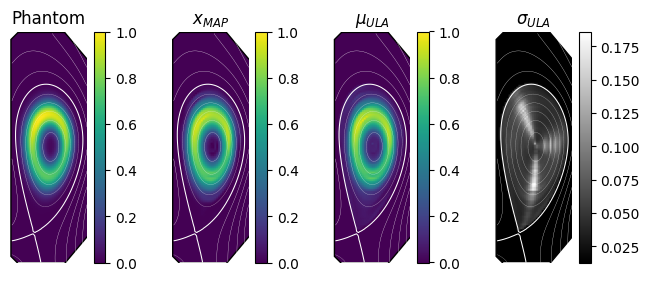

In [276]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True,
                        cmaps=["viridis", "viridis", "viridis", "gray"], vmax_std=np.max(np.sqrt(uq_data["var"])))

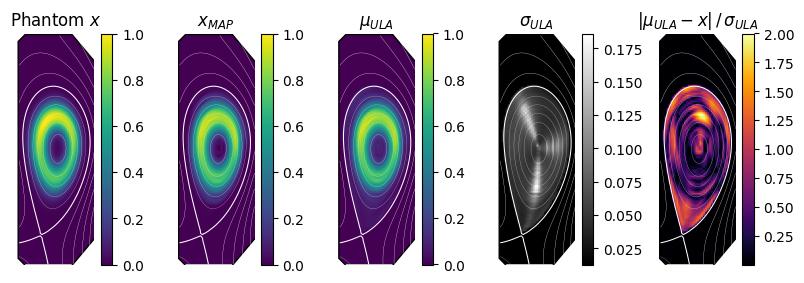

In [278]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_nb_stds=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "inferno"],
                        vmax_std=np.max(np.sqrt(uq_data["var"])), vmax_nb_std=2)

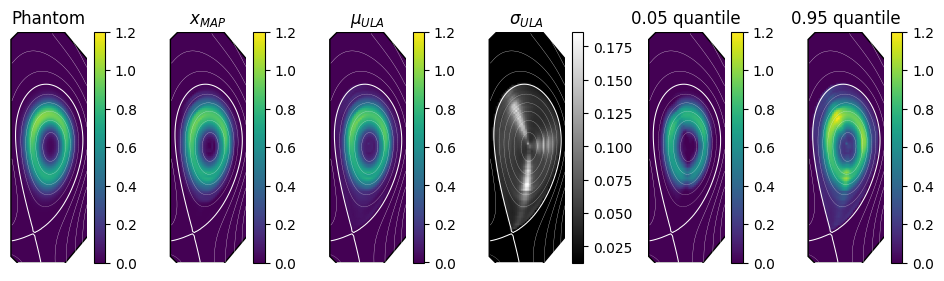

In [279]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

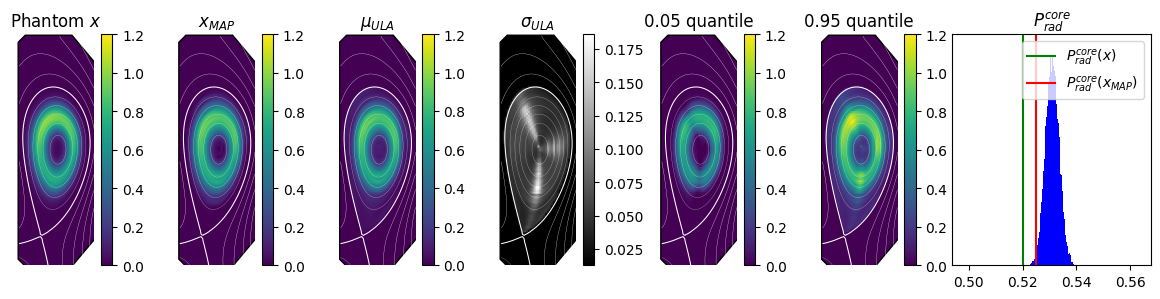

In [286]:
tomo_plots.plot_uq_data(uq_data=uq_data, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True, plot_prad=True,
                        mask_core=mask_tcv,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data["var"])))

In [283]:
gt_coarse = mask_core*skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][1,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-2,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print(frac_pixels_within_quantiles, frac_pixels_within_quantiles_core)

0.995625 0.9892197125256673


In [284]:
idxs =  np.where( (gt_coarse>=uq_data["empirical_quantiles"][0,:,:]) & (gt_coarse<=uq_data["empirical_quantiles"][-1,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print(frac_pixels_within_quantiles, frac_pixels_within_quantiles_core)

1.0 1.0


In [241]:
frac_pixels_within_quantiles = idxs[0].size / 4800

In [242]:
frac_pixels_within_quantiles

0.9364583333333333

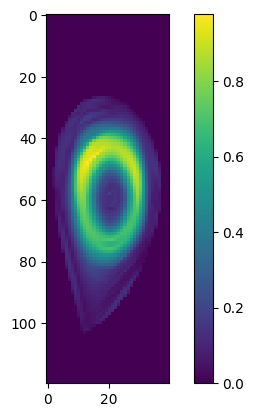

In [16]:
plt.imshow(np.clip(uq_data["mean"],0, None), cmap="viridis")
plt.colorbar()

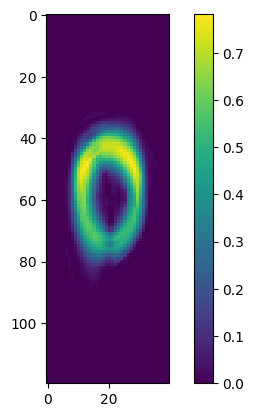

In [51]:
plt.imshow(np.clip(uq_data["empirical_quantiles"][1,:,:],0, None))
plt.colorbar()

In [52]:
True+True

2

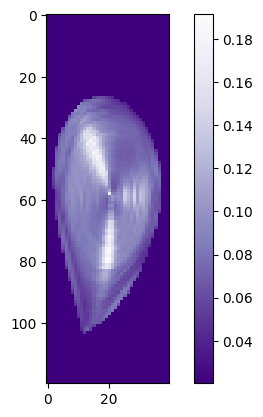

In [40]:
plt.imshow(np.sqrt(np.clip(uq_data["var"],0, None)), cmap="Purples_r")
plt.colorbar()

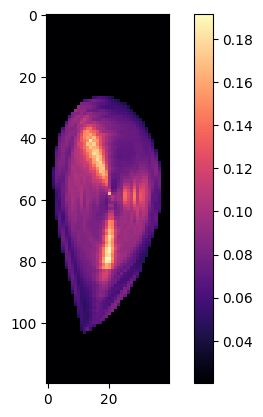

In [45]:
plt.imshow(np.sqrt(np.clip(uq_data["var"],0, None)), cmap="magma")
plt.colorbar()

In [ ]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch


dirname = os.path.dirname(__file__)


def plot_statistics_full(uq_data, ground_truth, psi):
    # Reshape ground truth and magnetic equilibrium if necessary
        # Reshape magnetic equilibrium if necessary
    if ground_truth.shape != uq_data["im_MAP"].shape:
        ground_truth = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
    if psi.shape != uq_data["im_MAP"].shape:
        psi = skimt.resize(psi, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
        
    fig, ax = plt.subplots(1, 3, figsize=(10,3), width_ratios=[1, 1, 1.25])
    im=ax[0].imshow(ground_truth, vmin=0, vmax=np.max(ground_truth))
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title("Ground truth")
    ax[1].axis('off')
    
    r = np.linspace(0, 40, 10)
    sxr_LoS_params = np.load(dirname + "/forward_model/sxr_LoS_params.npy")
    tcv_shape_coords = np.load(dirname + "/forward_model/tcv_shape_coords.npy")
    center = [20, 60]
    linewidth=0.5
    Lr=0.5
    Lz=1.5
    h=0.0125
    zs = np.linspace(0, Lz, round(Lz/h), endpoint=False)+0.5*h
    rs = np.linspace(0, Lr, round(Lr/h), endpoint=False)+0.5*h
    extent = copy.deepcopy(radcam.tile_extent_plot)
    extent[:,0] = extent[:,0] * rs.size - 0.5*h
    extent[:,1] = extent[:,1] * zs.size - 0.5*h
    path = Path(extent.tolist())
    patch=PathPatch(path, facecolor='none')
    #p = plt.imshow(gt, clip_path=patch, clip_on=True)
    ax[2].imshow(np.flip(gt, axis=0), origin="lower")
    #plt.colorbar()
    #plt.imshow(field_aligned_phantom)
    #plt.gca().add_patch(patch)
    #p.set_clip_path(patch)
    ax[2].axis('off')
    for i in range(LoS_params.shape[0]):
        if np.isclose(np.tan(LoS_params[i, 1]), 0, atol=1e-6):
            #plt.vlines(center[0] + LoS_params[i, 0], 0, Lz, "r")
            if center[0] + LoS_params[i, 0] < 0 or center[0] + LoS_params[i, 0] > 0.6:
                print("Vertical line does not intersect domain at x={}!".format(center[0] + LoS_params[i, 0]))
        else:
            p = LoS_params[i, 0]
            theta = LoS_params[i, 1]
            y = center[1] + p/h / np.sin(theta) - (r - center[0]) / np.tan(theta)
            # if np.min(y)>1.6 or np.max(y)<0:
            #    print("Line does not intersect domain!")
            ax[2].plot(r, y, "r", linewidth=linewidth)
    #ax[2].imshow(gt, origin="upper")
    ax[2].set_xlim([0, 40])
    ax[2].set_ylim([0, 120])
    ax[2].set_title("SXR diagnostic")

    ax[3].plot(tomo_data.T, '.', label="true")
    ax[3].plot(noisy_tomo_data.T, 'r.', label="noisy")
    ax[3].set_xlabel("LoS",  fontsize=12)
    ax[3].set_ylabel("I", rotation=0, fontsize=12, labelpad=10)
    ax[3].set_title("Tomographic data")
    ax[3].legend()
    plt.suptitle("Sample {}\n".format(s_id), fontsize=20, y=1.1)
    plt.show()

#===========================================================================

    # Reshape ground truth and magnetic equilibrium if necessary
    # Reshape magnetic equilibrium if necessary
    if ground_truth.shape != uq_data["im_MAP"].shape:
        ground_truth = skimt.resize(ground_truth, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')
    if psi.shape != uq_data["im_MAP"].shape:
        psi = skimt.resize(psi, uq_data["im_MAP"].shape, anti_aliasing=False, mode='edge')

    fig, ax = plt.subplots(1, 7, figsize=(14,3), width_ratios=[1, 1, 1, 0.5, 2, 1, 1])
    vmin=0
    vmax=np.max(gt)
    im=ax[0].imshow(data["mean"].reshape(arg_shape), vmin=vmin, vmax=vmax)
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title(r"$\mu_{ULA}$")
    im=ax[1].imshow(np.sqrt(data["var"]).reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[1].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title(r"$\sigma_{ULA}$")
    tbp = np.abs(data["mean"]-gt.flatten())
    tbp /= np.sqrt(data["var"])
    im=ax[2].imshow(tbp.reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[2].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title(r'$\frac{\vert \mu_{ULA} -ground\_truth \vert}{\sigma_{ULA}}$')
    ax[3].axis('off')
    im = ax[4].hist(data["prads_core"], bins=int(5e2), density=True, color="b")
    ax[4].set_title(r'$P_{rad}^{core},\;ULA\;$ empirical')
    ax[4].set_xlim(xrange_prad)
    ax[4].axvline(x=prad_core_true, ymin=0, ymax=30, color='g', label=r"true $P_{rad}^{core}$")
    ax[4].legend(loc="upper left")
    ax[4].set_yticks([])

    temp_low=np.zeros(N)
    temp_low[mask_core.flatten()] = data["empirical_quantiles"][0, :]
    im=ax[5].imshow(temp_low.reshape(arg_shape), vmax=vmax)#, vmin=vmin, vmax=vmax)
    ax[5].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[5])
    ax[5].axis('off')
    ax[5].set_title("0.05 quantile")
    temp_high=np.zeros(N)
    temp_high[mask_core.flatten()] = data["empirical_quantiles"][4, :]
    im=ax[6].imshow(temp_high.reshape(arg_shape), vmax=vmax)#, vmin=vmin, vmax=vmax)
    ax[6].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[6])
    ax[6].axis('off')
    ax[6].set_title("0.95 quantile")
    plt.show()

    #print("Fraction of pixels falling withing 90%-credible interval:  {}".format(frac_pix))

    fig, ax = plt.subplots(1, 7, figsize=(14,3), width_ratios=[1, 1, 1, 0.5, 2, 1, 1])
    im=ax[0].imshow(im_MAP.reshape(arg_shape), vmin=vmin, vmax=vmax)
    ax[0].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title(r"$MAP$")
    im=ax[1].imshow(np.sqrt(data["var_wrtMAP"]).reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[1].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title(r"$\sigma_{MAP}$")
    tbp = np.abs(im_MAP-gt.flatten())
    tbp /= np.sqrt(data["var_wrtMAP"])
    im=ax[2].imshow(tbp.reshape(arg_shape))#, vmin=vmin, vmax=vmax)
    ax[2].contour(psi, origin="lower", levels=10, antialiased=True, colors="r", linewidths=0.2)
    plt.colorbar(im, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title(r'$\frac{\vert MAP -ground\_truth \vert}{\sigma_{MAP}}$')
    ax[3].axis('off')

    #im = ax[4].hist(data["prads_core"], bins=int(5e2), density=True, color="b")
    ax[4].set_title(r"$P_{rad}^{MAP}$ estimates")
    ax[4].set_xlim(xrange_prad)
    ax[4].axvline(x=prad_core_true, ymin=0, ymax=30, color='g', label=r"true $P_{rad}^{core}$")
    ax[4].axvline(x=data["prad_map_core"], ymin=0, ymax=30, color='r', label=r"$P_{rad}^{MAP}$")
    ax[4].legend(loc="upper left")
    ax[4].set_yticks([])
    ax[5].axis('off')
    ax[6].axis('off')
    # plot_errbar_ax(ax[4], 1, data["prad_map_core"], np.sqrt(data["var_prad_wrtMAP_core"]), left=0.1, right=0.1, col="b", linewidth=2)
    # plt.plot(1, prad_core_true, 'g.', markersize=10, label=r"true $P_{rad}^{core}$")
    # ax[4].set_xlim([0,2])
    # ax[4].set_xticks([1])
    # ax[4].set_xticklabels([r"$P_{rad}^{core}$"])
    # ax[4].legend(loc="upper left")
    # ax[4].set_title(r"$P_{rad}^{MAP}$ estimates")
    plt.show()
